In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from functions import calculate_tss, calculate_hss, calculate_far, calculate_f1
import seaborn as sns
import sys
import random
from scipy import stats
from scipy.stats import anderson_ksamp, ks_2samp

# Read in Data

In [3]:
flares = pd.read_csv("Flares_SEPs_SHMARPs_t-2.dat", sep="\t")  # Adjust the 'sep' parameter according to your file's delimiter.
print(flares.columns)

Index(['t_start', 't_max', 't_end', 'class', 'location', 'AR', 'SEP_Match',
       'intensity', 'coords', 'ang_dist', 'T_OBS', 'ARPNUM', 'NOAA_AR',
       'CAR_ROT', 'USFLUXL', 'R_VALUE', 'MEANGBL_GMM', 'MEANGBZ', 'USFLUXZ',
       'CMASKL', 'LAT_FWT', 'CRLT_OBS', 'LON_FWT', 'CRLN_OBS', 'CDELT1',
       'DSUN_OBS', 'RSUN_OBS', 'ANG_DIST_AR', 'time_diff'],
      dtype='object')


# Check Some Stats

In [4]:
# Separate the DataFrame into positive and negative datasets
positive_flares = flares[flares['SEP_Match'] == True]
negative_flares = flares[flares['SEP_Match'] == False]

# Filter out rows with 'time_diff' less than -3000 for positive flares
positive_flares = positive_flares[positive_flares['time_diff'] >= -3000]
negative_flares = negative_flares[negative_flares['time_diff'] >= -3000]

# Drop NA
positive_flares = positive_flares.dropna()
negative_flares = negative_flares.dropna()

print(np.shape(negative_flares))
print(np.shape(positive_flares))

(3187, 29)
(107, 29)


## Remove SEP-Causing ARs from Negative List (optional)

In [5]:
remove_active = False
if remove_active == True:
    sep_ars = set(positive_flares['AR'])
    print(len(negative_flares))
    negative_flares = negative_flares[~negative_flares['AR'].isin(sep_ars)]
    print(len(negative_flares), negative_flares)

/var/folders/f3/0cy8rn755wb09kvtmdwcsp682r4dkc/T/ipykernel_67799/2334109844.py:4: UserWarning: p-value floored: true value smaller than 0.001
  anderson_result_intensity = anderson_ksamp([np.log(positive_flares['intensity']), np.log(negative_flares['intensity'])])
/var/folders/f3/0cy8rn755wb09kvtmdwcsp682r4dkc/T/ipykernel_67799/2334109844.py:5: UserWarning: p-value floored: true value smaller than 0.001
  anderson_result_ang_dist = anderson_ksamp([positive_flares['ang_dist'], negative_flares['ang_dist']])


Anderson_ksampResult(statistic=170.98515947718892, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
Anderson_ksampResult(statistic=23.497926186653554, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
KstestResult(statistic=0.6321270113105519, pvalue=1.874605802351048e-40, statistic_location=-10.231991619508165, statistic_sign=-1)
KstestResult(statistic=0.30141139969912817, pvalue=7.769967368428939e-09, statistic_location=-0.4028583740558391, statistic_sign=-1)


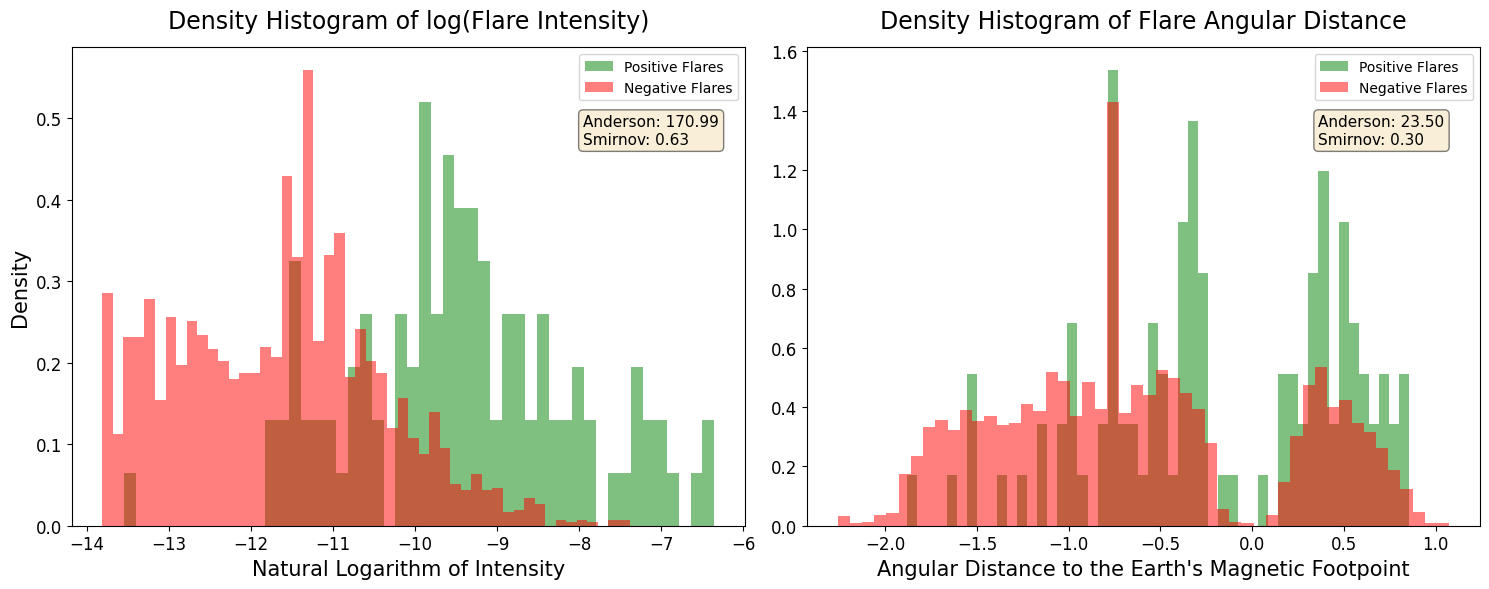

In [10]:
# Calculate t-statistic and p-value for 'intensity' and 'ang_dist'
#t_stat_intensity, p_val_intensity = stats.ttest_ind(np.log(positive_flares['intensity']),np.log(negative_flares['intensity']),equal_var=False)  # Assuming unequal population variances
#t_stat_ang_dist, p_val_ang_dist = stats.ttest_ind(positive_flares['ang_dist'],negative_flares['ang_dist'],equal_var=False)  # Assuming unequal population variances
anderson_result_intensity = anderson_ksamp([np.log(positive_flares['intensity']), np.log(negative_flares['intensity'])])
anderson_result_ang_dist = anderson_ksamp([positive_flares['ang_dist'], negative_flares['ang_dist']])
print(anderson_result_intensity)
print(anderson_result_ang_dist)

# Calculate the Kolmogorov-Smirnov statistic for the two samples
ks_result_intensity = ks_2samp(np.log(positive_flares['intensity']), np.log(negative_flares['intensity']))
ks_result_ang_dist = ks_2samp(positive_flares['ang_dist'], negative_flares['ang_dist'])
print(ks_result_intensity)
print(ks_result_ang_dist)

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Histogram for 'intensity' with log scale on the x-axis
ax1.hist(np.log(positive_flares['intensity']), bins=50, alpha=0.5, label='Positive Flares', color='g', density=True)
ax1.hist(np.log(negative_flares['intensity']), bins=50, alpha=0.5, label='Negative Flares', color='r', density=True)
ax1.set_xlabel('Natural Logarithm of Intensity', fontsize=15)
ax1.set_ylabel('Density', fontsize=15)
ax1.set_title('Density Histogram of log(Flare Intensity)', fontsize=17, pad=14)
ax1.legend()
# Add text box for t-statistic and p-value for 'intensity'
textstr = f'Anderson: {anderson_result_intensity.statistic:.2f}\nSmirnov: {ks_result_intensity.statistic:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.76, 0.86, textstr, transform=ax1.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

# Histogram for 'ang_dist'
ax2.hist(positive_flares['ang_dist'], bins=50, alpha=0.5, label='Positive Flares', color='g', density=True)
ax2.hist(negative_flares['ang_dist'], bins=50, alpha=0.5, label='Negative Flares', color='r', density=True)
ax2.set_xlabel('Angular Distance to the Earth\'s Magnetic Footpoint', fontsize=15)
ax2.set_ylabel('')
ax2.set_title('Density Histogram of Flare Angular Distance', fontsize=17, pad=14)
ax2.legend()
# Add text box for t-statistic and p-value for 'ang_dist'
textstr = f'Anderson: {anderson_result_ang_dist.statistic:.2f}\nSmirnov: {ks_result_ang_dist.statistic:.2f}'
ax2.text(0.76, 0.86, textstr, transform=ax2.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

# Increase tick label size for both axes
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
